This example demonstrates requesting gridded data from ERDDAP and plotting the returned data in polar projection with cartopy. 

In [42]:
%matplotlib inline
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from netCDF4 import Dataset as netcdf_dataset
import numpy as np
import urllib3 
import cartopy
import cartopy.crs as ccrs
import os
import dateutil.parser
from dateutil.relativedelta import *
from datetime import datetime, timedelta

# define dataset, parameter and time for data request
datasetId = 'jplMURSST41'
param = 'analysed_sst'
time = '2018-03-07T09:00:00Z'

# Define area for data request 
# from -50 degrees to the south pole, reducing data request latutudinal resolution by a factor of 100
lat1 = -89.99
lat2 = -60
# all longitudes, reducing by a factor of 100
lon1 = -179.99
lon2 = 180.00

base_url = 'https://polarwatch.noaa.gov/erddap/griddap/'+ datasetId +'.nc?'

timeQuery = '[(%s):%s:(%s)]' % (time,'1',time)

latQuery  = '[(%s):%s:(%s)]' % (lat1,'100',lat2)

lonQuery  = '[(%s):%s:(%s)]' % (lon1,'100',lon2)

query = param + timeQuery + latQuery + lonQuery


# Note that datasets in ERDDAP may for may not have an altitude dimension. 
# An altitude request is required if the dataset includes an altidude dimension.
# Here is example formatting of a request with altitude:
# query = param +'[(%s):%s:(%s)][(%s):%s:(%s)][(%f):%s:(%f)][(%f):%s:(%f)]' % (timestart,timesub,timeend,altMin,altsub, altMax,lat1,latsub,lat2,minlon,lonsub,maxlon)

requestUrl = base_url + query

print(' * NetCDF Url: ' + requestUrl)

 * NetCDF Url: https://polarwatch.noaa.gov/erddap/griddap/jplMURSST41.nc?analysed_sst[(2018-03-07T09:00:00Z):1:(2018-03-07T09:00:00Z)][(-89.99):100:(89.99)][(-179.99):100:(180.0)]


In [43]:
# Request the data from ERDDAP

# Filename, location to store the requested data
file = 'dataset.nc'

http = urllib3.PoolManager()
r = http.request('GET', requestUrl, preload_content=False)

with open(file, 'wb') as out:
    while True:
        data = r.read(1024*1024)
        if not data:
            break
        out.write(data)

r.release_conn()

#netcdf data object
dataset = netcdf_dataset(file)


/home/jenn/anaconda2/envs/geo3/lib/python3.6/site-packages/urllib3/connectionpool.py:852: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [ ]:
# Open netcdf and get data for plotting

data = dataset.variables[param][0, :, :]
lats = dataset.variables['latitude'][:]
lons = dataset.variables['longitude'][:]

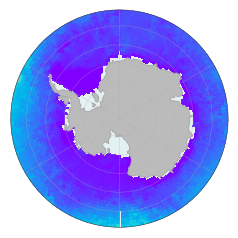

In [48]:
# Make a polar plot using cartopy

fig = plt.figure()    

# Set area ouside of circle to transparent
fig.patch.set_facecolor('blue')
fig.patch.set_alpha(0.0)

ax1 = plt.axes(projection = ccrs.SouthPolarStereo() )
ax1.set_global()

# Compute a circle in axes coordinates, to use as a boundary
#   for the map.
theta = np.linspace( 0, 2 * np.pi, 100 )
center, radius = [0.5, 0.5], 0.5
verts = np.vstack( [np.sin(theta), np.cos(theta)] ).T
circle = mpath.Path( verts * radius + center )
ax1.set_boundary( circle, transform = ax1.transAxes)

# set plot background color (water)
ax1.set_facecolor('#e4f1f2')

#get data limits
vmaxData = np.amax(data)
vminData = np.amin(data)

colormap = 'rainbow'
dataplt = ax1.pcolormesh(lons,lats,data,vmin=vminData,cmap=colormap,vmax=vmaxData,transform=ccrs.PlateCarree())

# reduce equatorward extent
ax1.set_extent([-4000000, 4000000, -4000000, 4000000], thisproj)

# Add Land
ax1.add_feature( cartopy.feature.LAND, zorder=1, edgecolor='none', facecolor='#bbbbbb') #fae5c9')

# Add coastline
ax1.coastlines(color='#aaaaaa')

# Add lat lon rings
ax1.gridlines(alpha='0.3')

# Make border thinner
ax1.outline_patch.set_linewidth(0.5)
ax1.outline_patch.set_edgecolor('#333333')
plt.show()
      